##
Link to article :

https://arxiv.org/pdf/2407.14225#page=5.78

ref git : https://github.com/gardiens/MVA_24_25/blob/main/mva_geom/TD6/TP_6.ipynb


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from slices import display_multi_slices, get_sdf_image
from tqdm.auto import tqdm
from synthetic_data import sphere_data, square_data
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
device
from src.models.Sirenlayer import SirenNet
from src.optimize import optimize_nise_vf
from src.results.display import display_result

In [1]:
!jupyter server list


Currently running servers:
http://dgxa100:8883/ :: /raid/home/bournez_pie/mva_geom/mva_geom_24/NPM3D/Project/Noise2NoiseMapping_pytorch


In [2]:
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf


In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from slices import display_multi_slices, get_sdf_image
from tqdm.auto import tqdm
from synthetic_data import sphere_data, square_data
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
device

device(type='cuda')

In [4]:
#print torch cuda version
print(torch.version.cuda)

12.1


## Models for the point clouds ! 

In [4]:
from src.models.Sirenlayer import SirenLayer,SirenNet
input = torch.randn(2000, 3)
layer = SirenLayer(3, 256, is_first=True)
layer(input)

input = torch.randn(2000, 3, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
net(input).shape


the size 0.005103103630798287
the size 0.005103103630798287
the size 0.005103103630798287
the size 0.005103103630798287


torch.Size([2000, 1])

In [6]:
class SirenLayer(nn.Module):
    def __init__(
        self, in_features, out_features, bias=True, is_first=False, omega_0=30
    ):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        ## Create the layer, and initialize it. You can do it in init_weights

        self.fc1 = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                ## Initialization of first layer type
                size = 1 / self.in_features
            else:
                size = np.sqrt(6 / self.in_features) / self.omega_0
                ## Other initialization
            self.fc1.weight.uniform_(-size, size)

    def forward(self, input):
        ## Logic
        return torch.sin(self.omega_0 * self.fc1(input))


input = torch.randn(2000, 3)
layer = SirenLayer(3, 256, is_first=True)
layer(input)
class SirenNet(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out, num_layers, skip=[], omega_0=30.0):
        super().__init__()
        self.num_layers = num_layers
        self.dim_hidden = dim_hidden
        self.skip = [i in skip for i in range(num_layers)]
        self.omega_0 = omega_0
        layers_list = []
        ## Create layer
        # first layer
        layers_list.append(
            SirenLayer(
                in_features=dim_in,
                out_features=dim_hidden,
                is_first=True,
                omega_0=omega_0,
            )
        )
        for k in range(1, num_layers):
            layers_list.append(
                SirenLayer(
                    in_features=dim_hidden,
                    out_features=dim_hidden,
                    is_first=False,
                    omega_0=omega_0,
                )
            )
        ## Last layer is a simple linear layer. Don't forget to intialize your weights as before!
        self.skip.append(False)
        self.last_layer = nn.Linear(dim_hidden, dim_out, bias=True)
        ## Init last layer
        size = np.sqrt(6 / dim_in) / self.omega_0
        with torch.no_grad():
            self.last_layer.weight.uniform_(-size, size)
        # create the network
        self.layers = nn.ModuleList(layers_list)

    def forward(self, x):
        ## Network logic
        ## You can ignore skip connections at the beginning
        #! The skip is never initialized so we don't know what is exactly this parameters,
        #! we assume it's a list of index where we have to skip the connection

        for index, layer in enumerate(self.layers):
            if self.skip[index]:
                x = x + layer(x)
            else:
                x = layer(x)
        output = self.last_layer(x)
        return output


input = torch.randn(2000, 3, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
net(input).shape

torch.Size([2000, 1])

In [7]:
from src.models.DeepSDF import SDFNet
input = torch.randn(2000, 3, device=device)
net = SDFNet(ninputchannels=3).to(device)
net(input).shape


torch.Size([2000, 1])

# Create the data

In [8]:
from src.loss.utils import * 

## Loss functions 

In [9]:
from src.loss.utils import project_pc
input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
project_pc(net,input_pc).shape

torch.Size([2000, 3])

In [10]:
# data should be 0 on the shape
from src.loss.loss_data import loss_data,loss_normalign,loss_shape_data


In [11]:
import numpy as np
import ot

## Compute  Earth mover distance

In [12]:

input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
project_pc(net,input_pc).shape

torch.Size([2000, 3])

In [13]:
from src.loss import compute_EMD
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5).to(device)

input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
loss=compute_EMD(net,input_pc,2000)
loss.backward()#! THIS IS CUda compatible?!!
loss

tensor(0.0557, device='cuda:0', grad_fn=<ValFunctionBackward>)

### geomloss?

In [14]:
import torch
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss

# Create some large point clouds in 3D
x = torch.randn(100000, 3, requires_grad=True).cuda()
y = torch.randn(200000, 3).cuda()

# Define a Sinkhorn (~Wasserstein) loss between sampled measures
loss = SamplesLoss(loss="sinkhorn")

L = loss(x, y)  # By default, use constant weights = 1/number of samples
g_x, = torch.autograd.grad(L, [x])  # GeomLoss fully supports autograd!
g_x

tensor([[ 9.9206e-08, -1.0204e-07,  1.6353e-07],
        [ 1.5966e-07,  7.4270e-08,  1.4236e-07],
        [ 7.7762e-09, -1.0340e-07, -4.0047e-08],
        ...,
        [ 3.7867e-08, -3.2758e-07, -4.9431e-07],
        [ 8.2299e-08,  4.4916e-08, -2.8458e-07],
        [-1.1229e-08, -1.8011e-07,  1.2470e-07]], device='cuda:0')

# weird amb loss

In [16]:
from src.loss.loss_data import loss_amb

In [17]:
from src.loss.loss_data import loss_amb

pc_hint=torch.randn(10000,3,device=device)
gt_sdf=torch.randn(10000,3,device=device)
net=SirenNet(dim_in=3,dim_hidden=256,dim_out=1,num_layers=5).to(device)
loss_amb(net,pc_hint,gt_sdf)

tensor(10.3286, device='cuda:0', grad_fn=<MulBackward0>)

# EMD LOSS 

In [18]:
from src.loss.loss_emd import * 
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad
def project_pc(net,input_pc):
    # apply F (n, fθ ) = n − d × ∇fθ (n, c)/||∇fθ (n, c)||2
    d= net(input_pc)
    grad= gradient(d, input_pc)
    print("d",d.shape)
    print("grad norm",grad.shape)
    print("input_pc",input_pc.shape)
    test=grad/ torch.norm(grad, dim=1).view(-1,1)

    return input_pc - d * grad/ torch.norm(grad, dim=1).view(-1,1)
        
input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
loss_geom=EMD_loss()
compute_EMD_geomloss(net,input_pc,2000,loss_geom)

tensor(0.0128, device='cuda:0', grad_fn=<SelectBackward0>)

## Pull Loss

In [19]:
from src.loss.loss_gc import * 
input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
net= SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
loss_geometric_consistency(net,input_pc)

tensor(8.8745, device='cuda:0', grad_fn=<MulBackward0>)

In [20]:

input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
net= SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
loss_geometric_consistency3(net,input_pc,dim_space=3)

tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)

In [21]:

input_pc= torch.randn(2000, 3, device=device)
input_pc.requires_grad = True
net= SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
loss_geometric_consistency2(net,input_pc,dim_space=3)

tensor(0.1355, device='cuda:0', grad_fn=<MeanBackward0>)

## compute the eikonal loss

In [22]:
from src.loss.loss_eik import * 

net = SirenNet(dim_in=2, dim_hidden=256, dim_out=1, num_layers=5).to(device)
loss_eikonal(net, 2000, 2)

tensor(3.1061, device='cuda:0', grad_fn=<MeanBackward0>)

# Complete loss

In [23]:
from src.optimize import evaluate_loss_cst_vf
pc_input = torch.randn(10000, 3, device=device)
# pc_input.requires_grad = True
normals = torch.randn(10000, 2, device=device)
hints_pc = torch.randn(100000, 3, device=device)
gtsdf = torch.randn(100000, device=device)
vf = torch.randn(2, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=3, num_layers=5).to(device)
lpc = []
leik = []
lh = []
llse = []
lemd=[]
lgc=[]
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
net = net.to(device)
evaluate_loss_cst_vf(net=net,
                     pc=pc_input,
                    #  normals=normals,
                    #  hints_pc=hints_pc,
                    #  gtsdf=gtsdf,
                    #  vf=vf,
                    #  lpc=lpc,
                    #  leik=leik,
                    #  lemd=lemd,
                    #  lgc=lgc,
                     dim_space=3,
                     list_loss=list_loss,
                     )

tensor(13.6367, device='cuda:0', grad_fn=<AddBackward0>)

# Display results

In [24]:
from src.results.display import * 

# Run function

In [25]:
from src.optimize import optimize_nise_vf

# actual data :
For work only 2D canonical shape(?)

In [26]:
import numpy as np

(200, 200)


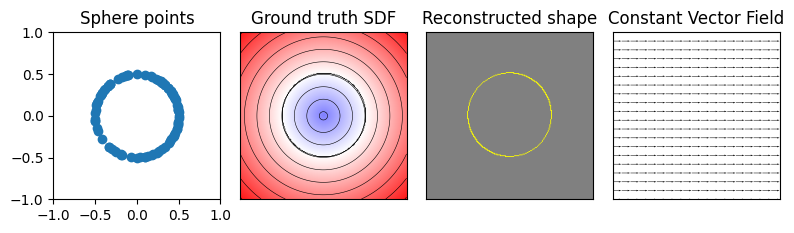

In [27]:
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
    10000, 100000
)

# constant vector field (a single vector)
vf = torch.tensor([0.3, 0.0], device=device)


fig, axs = plt.subplots(1, 4, figsize=(8, 15))
pc_numpy = pc0.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0 / axs[0].get_data_ratio(), adjustable="box")
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Sphere points")
sdf_numpy = sdf_coords.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors="k", linewidths=0.4, linestyles="solid")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
print(sdf_numpy.shape)
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")


def get_vector_field_meshgrid(X_value, Y_value):
    # Create a grid of points
    x = np.linspace(-1, 1, 20)
    y = np.linspace(-1, 1, 20)
    X, Y = np.meshgrid(x, y)

    # Define the constant vector field (e.g., constant vector [1, 1] everywhere)
    U = np.ones_like(X) * X_value / (10 * max(X_value, Y_value))  # constant x-component
    V = np.ones_like(Y) * Y_value / (10 * max(X_value, Y_value))  # constant y-component
    return X, Y, U, V


X, Y, U, V = get_vector_field_meshgrid(vf[0].item(), vf[1].item())
axs[3].quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=1)
axs[3].set_xlim((-1, 1))
axs[3].set_ylim((-1, 1))
axs[3].set_aspect("equal")
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].set_title("Constant Vector Field")
axs[3].grid()
plt.tight_layout()
plt.show()

In [28]:
npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]
list_loss={"emd":[],"gc":[],"eik":[]}


starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0.01, lambda_lse=2, lambda_gc=0.001, lambda_emd=1


Training:   0%|          | 0/5000 [00:00<?, ?it/s, loss=16.1]

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


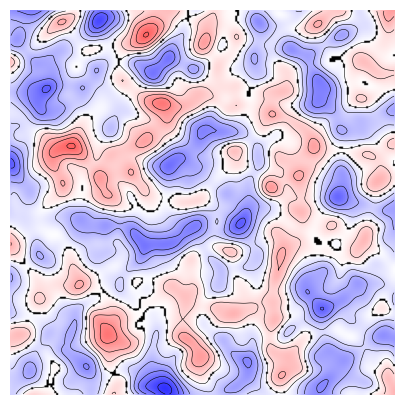

Training:  40%|████      | 2001/5000 [01:15<01:50, 27.16it/s, loss=0.0101] 

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


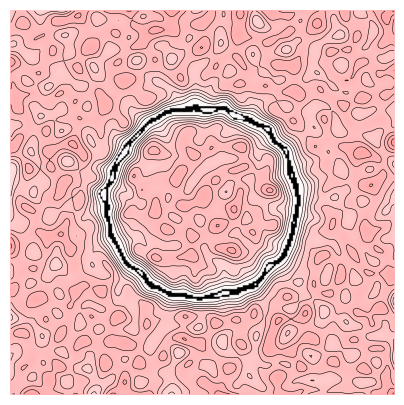

Training:  80%|████████  | 4001/5000 [02:41<00:37, 26.87it/s, loss=0.00988]

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


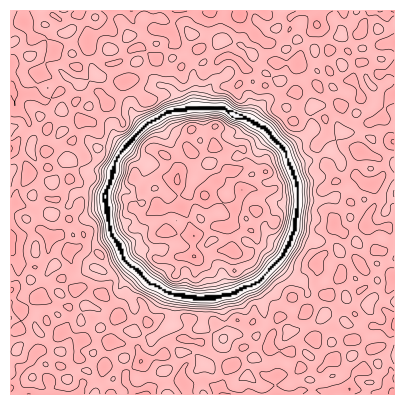

Training: 100%|██████████| 5000/5000 [03:18<00:00, 25.14it/s, loss=0.00963]

Optimizing NN took 198.91 s.


In [30]:

npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=5000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    lambda_pc=0,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, # used but need ground truth,
    lambda_lse=2, # not used,
    lambda_gc=0.001, #geometric consistency,
    lambda_emd=1, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
)

# torch.save(true_net, "net_vf_{}_{}.net".format(npl, depth))

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


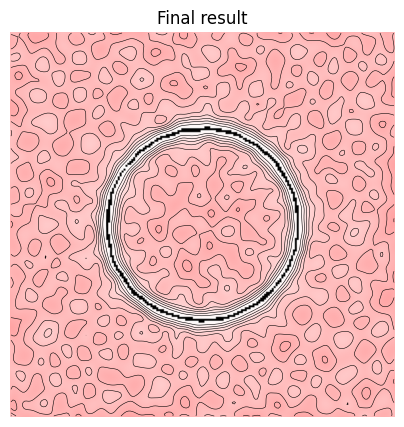

In [ ]:
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")

coords shape before adding t: torch.Size([160000, 2])
sdf shape before reshape: torch.Size([160000, 1])


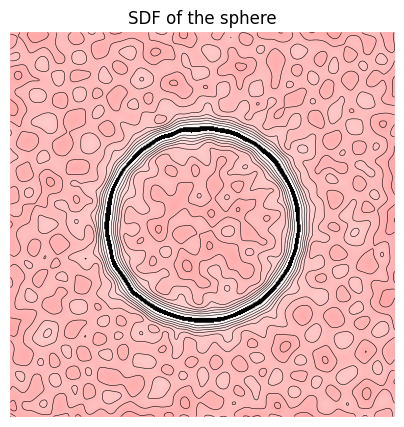

In [ ]:
display_result(true_net, resolution=400, figsize=(14, 5),title="SDF of the sphere",eps=0.01)

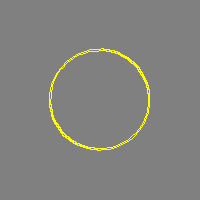

In [ ]:
resolution=200

coords = torch.stack(list(torch.meshgrid([torch.linspace(-1, 1, resolution, device = device)]*2, indexing = 'xy')), dim=2)#.reshape(-1, 2)

coords=coords.reshape(-1,2)
coords.requires_grad=True
sdf_data=true_net(coords)

sdf_data=sdf_data.squeeze(-1).reshape(resolution,resolution)
sdf_numpy = sdf_data.detach().cpu().numpy()
get_img_marching_squares(sdf_numpy,threshold=0.005)

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


/tmp/ipykernel_4170139/2987464184.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2= torch.load("net_vf_128_3.net")


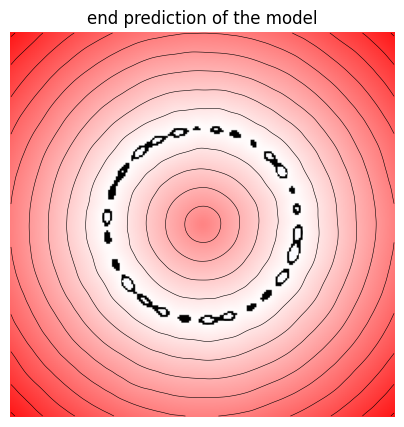

In [ ]:
net2= torch.load("net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="end prediction of the model")

## Interlude

In [ ]:
true_net = SDFNet(ninputchannels=2).to(device)

npl = 128
depth = 3
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]
list_loss={"emd":[],"gc":[],"eik":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
nepochs = 10000
nepochs=5000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    # hints0=pts_hintst0,
    # gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    lambda_pc=1,# not used,
    lambda_eik=0.001, # eikonal,
    lambda_hint=1, # ot used,
    lambda_lse=2, # not used,
    lambda_gc=0.001, #geometric consistency,
    lambda_emd=1, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
)


## Fin interlude

/tmp/ipykernel_4170139/3125651321.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net2= torch.load("net_vf_128_3.net")


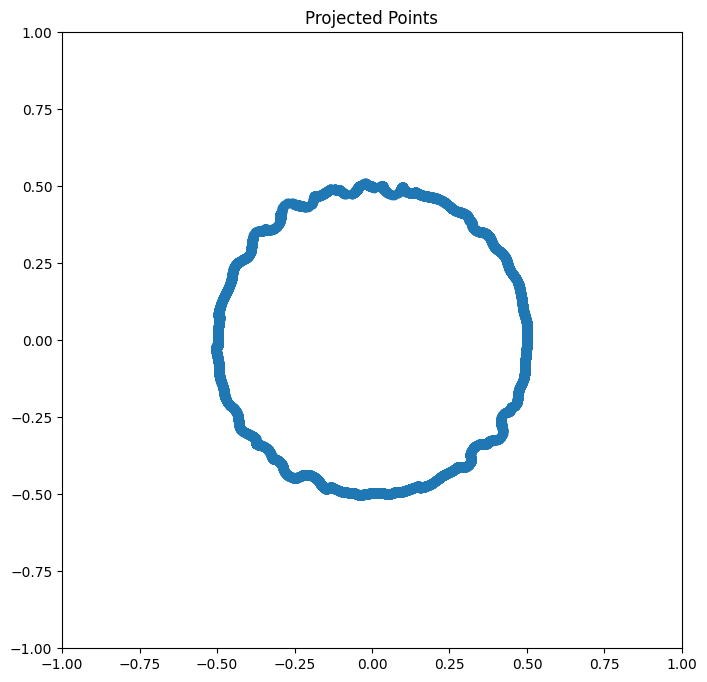

In [ ]:
import torch
import matplotlib.pyplot as plt

def display_projection(net, input_pc):
    """
    Projects the input point cloud onto a learned surface using the SDF network 
    and displays the projected points in 2D.
    """
    # Compute signed distance and gradient
    d = net(input_pc)
    grad = gradient(d, input_pc)
    
    # Compute the projected points
    S_projected = input_pc - d * grad / torch.norm(grad, dim=1, keepdim=True)

    # Display as 2D scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))  # Fix subplot initialization
    pc_numpy = S_projected.detach().cpu().numpy()

    ax.scatter(pc_numpy[:, 0], pc_numpy[:, 1])
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_title("Projected Points")

    plt.show()

pc_t0 = pc0.clone().to(device)
pc_t0.requires_grad = True
display_projection(net2,pc_t0)


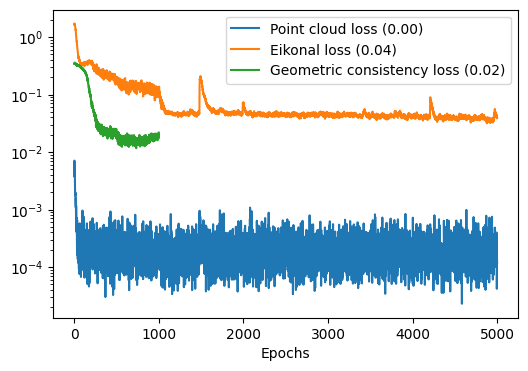

In [ ]:
def display_loss(list_loss):
    lgc=list_loss["gc"]
    lpc=list_loss["emd"]
    leik=list_loss["eik"]
    plt.figure(figsize=(6, 4))
    plt.yscale("log")
    plt.plot(lpc, label="Point cloud loss ({:.2f})".format(lpc[-1]))
    plt.plot(leik, label="Eikonal loss ({:.2f})".format(leik[-1]))
    plt.plot(lgc, label="Geometric consistency loss ({:.2f})".format(lgc[-1]))
    plt.xlabel("Epochs")
    plt.legend()
display_loss(list_loss)

In [ ]:
for lambda_gc in [10**-k for k in range(2,6)]:
    npl = 128
    depth = 3
    true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
        device
    )
    lpc, leik, lh, llse = [], [], [], []
    lemd=[]
    lgc=[]
    list_loss={"emd":[],"gc":[],"eik":[]}
    pc_t0 = pc0.clone().to(device)
    pts_hintst0 = pts_hints0.clone().to(device)
    nepochs = 10000
    pc_t0.requires_grad = True
    # nepochs=10
    optimize_nise_vf(
        net=true_net,
        pc0=pc_t0,
        # nc0=nc0,
        # hints0=pts_hintst0,
        # gtsdf0=gt_sdf_hints0,
        # vf=vf,
        # lpc=lpc,
        # leik=leik,
        # lh=lh,
        # llse=llse,
        # lemd=lemd,
        # lgc=lgc,
        lambda_pc=1,# not used,
        lambda_eik=0.001, # eikonal,
        lambda_hint=1, # ot used,
        lambda_lse=2, # not used,
        lambda_gc=lambda_gc, #geometric consistency,
        lambda_emd=1, # lambda EMD,
        batch_size=6000,
        nepochs=nepochs,
        plot_loss=False,
        follow_paper=False,
        list_loss=list_loss,
    )
    net2= torch.load("net_vf_128_3.net")
    # net2= torch.load("net_vf_128_3.net")
    display_result(true_net, resolution=200, figsize=(14, 5),title=f"lambda_gc={lambda_gc}")
    display_loss(list_loss)


In [ ]:
for batch_size in [1000,2000,5000,10000,50000]:
    npl = 128
    depth = 3
    true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
        device
    )
    lpc, leik, lh, llse = [], [], [], []
    lemd=[]
    lgc=[]
    list_loss={"emd":[],"gc":[],"eik":[]}
    pc_t0 = pc0.clone().to(device)
    pts_hintst0 = pts_hints0.clone().to(device)
    nepochs = 10000
    pc_t0.requires_grad = True
    # nepochs=10
    optimize_nise_vf(
        net=true_net,
        pc0=pc_t0,
        # nc0=nc0,
        # hints0=pts_hintst0,
        # gtsdf0=gt_sdf_hints0,
        # vf=vf,
        # lpc=lpc,
        # leik=leik,
        # lh=lh,
        # llse=llse,
        # lemd=lemd,
        # lgc=lgc,
        lambda_pc=1,# not used,
        lambda_eik=0.01, # eikonal,
        lambda_hint=1, # ot used,
        lambda_lse=2, # not used,
        lambda_gc=0.001, #geometric consistency,
        lambda_emd=1, # lambda EMD,
        batch_size=batch_size,
        nepochs=nepochs,
        plot_loss=False,
        follow_paper=False,
        list_loss=list_loss,
    )
    net2= torch.load("net_vf_128_3.net")
    # net2= torch.load("net_vf_128_3.net")
    display_result(true_net, resolution=200, figsize=(14, 5),title=f"batch_size={batch_size}")
    display_loss(list_loss)


beware HARDCODED version


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_pc is null
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


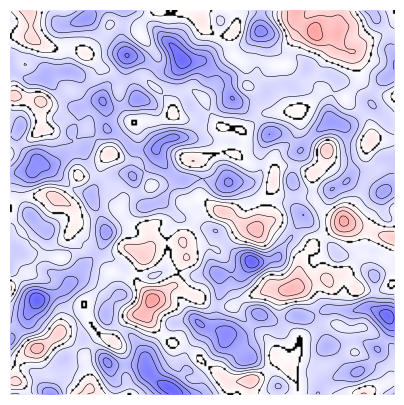

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


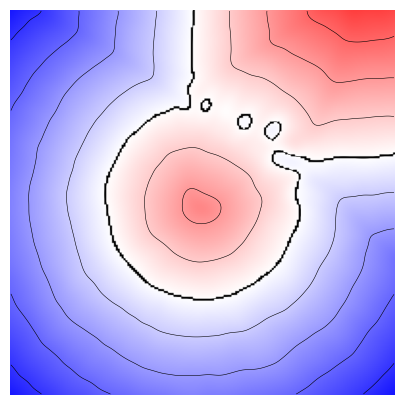

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


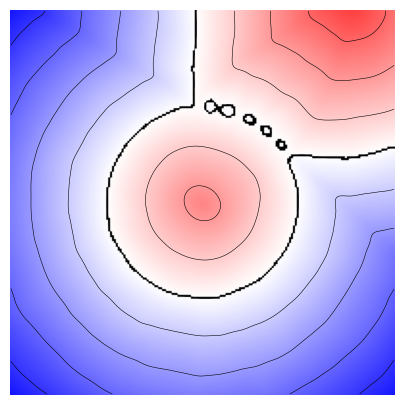

Optimizing NN took 139.60 s.


NameError: name 'display_loss' is not defined

In [ ]:

npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=5000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    lambda_pc=0,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.001, #geometric consistency,
    lambda_emd=1, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=True,
    list_loss=list_loss,
)
#display the loss
display_loss(list_loss)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_pc is null
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


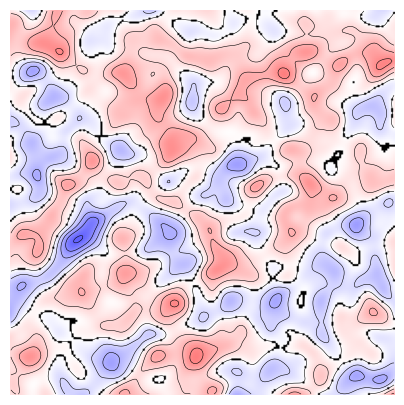

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


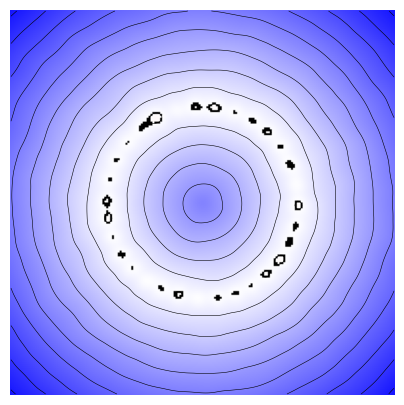

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


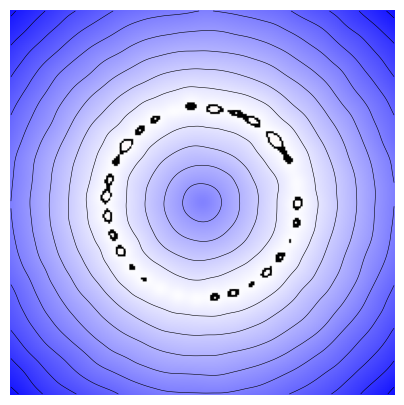

Optimizing NN took 159.14 s.


In [ ]:

#! The value  Ifound 

npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=5000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    lambda_pc=0,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=1, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
)
#display the loss

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

lambda_emd is null
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


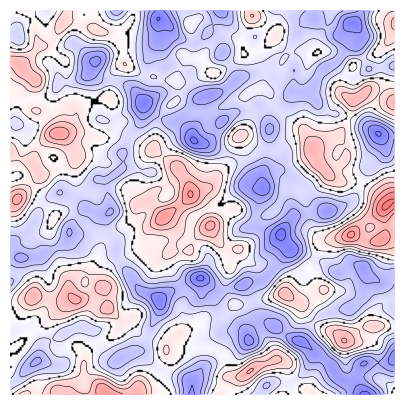

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


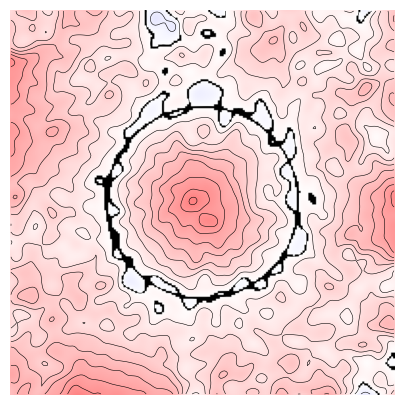

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


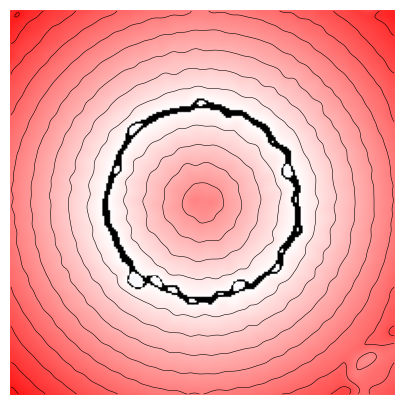

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


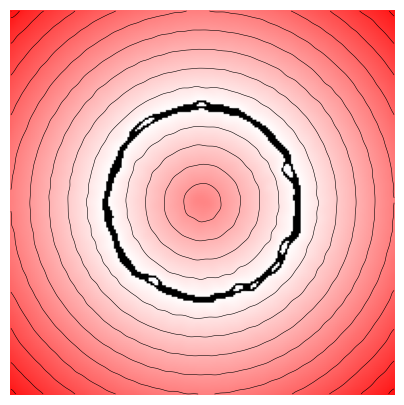

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


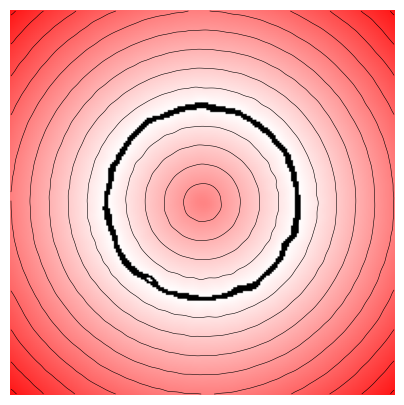

Optimizing NN took 96.52 s.
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


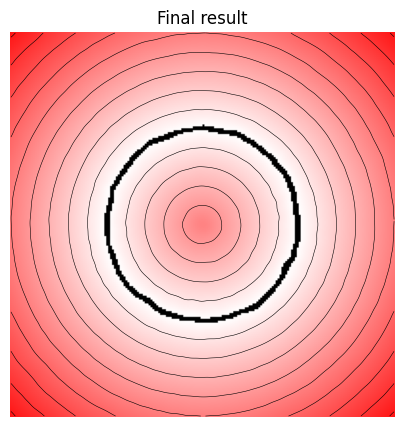

In [ ]:

#! with some help  

npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=10000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=1,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=0, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")

:warning: the image is biased because sometime some part of it is missing

coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


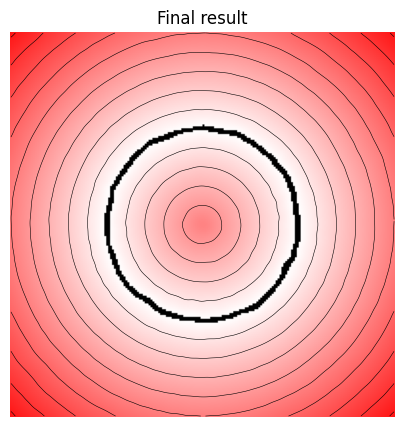

In [ ]:
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")

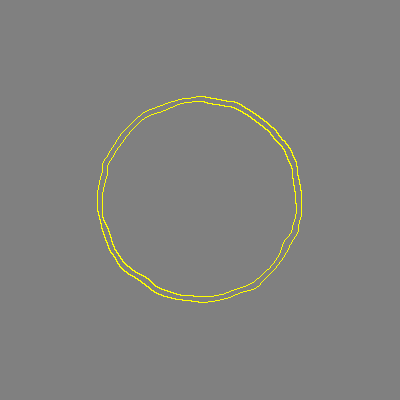

In [ ]:
resolution=400

coords = torch.stack(list(torch.meshgrid([torch.linspace(-1, 1, resolution, device = device)]*2, indexing = 'xy')), dim=2)#.reshape(-1, 2)

coords=coords.reshape(-1,2)
coords.requires_grad=True
sdf_data=true_net(coords)

sdf_data=sdf_data.squeeze(-1).reshape(resolution,resolution)
sdf_numpy = sdf_data.detach().cpu().numpy()
get_img_marching_squares(sdf_numpy,threshold=0.005)

## Fine Tune the point loss?

lambda_pc 1000
starting loss, lambda_pc=1000, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_emd is null
Optimizing NN took 46.77 s.
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


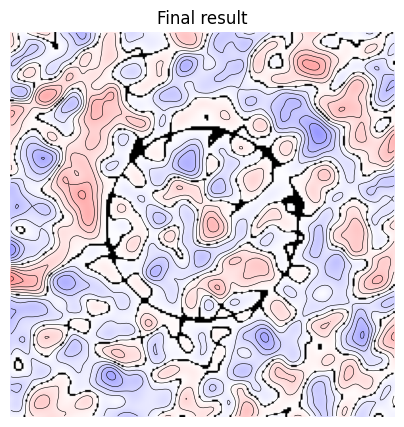

lambda_pc 100
starting loss, lambda_pc=100, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_emd is null
Optimizing NN took 47.10 s.
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


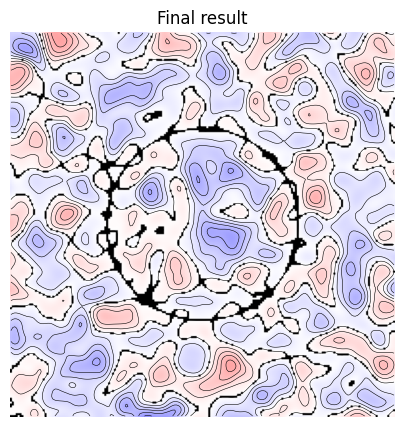

lambda_pc 10
starting loss, lambda_pc=10, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_emd is null
Optimizing NN took 46.63 s.
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


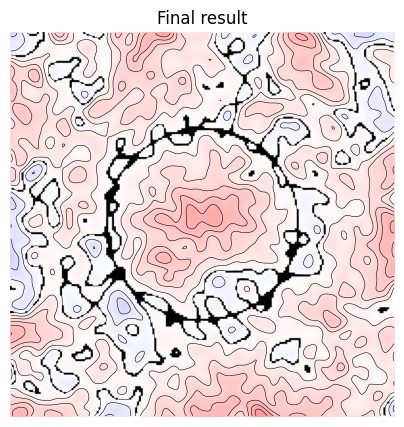

lambda_pc 1
starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_emd is null
Optimizing NN took 46.80 s.
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


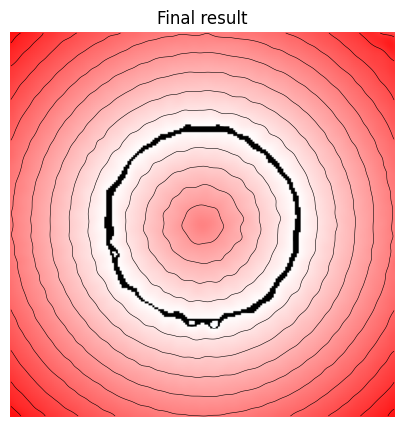

lambda_pc 0.1
starting loss, lambda_pc=0.1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_emd is null
Optimizing NN took 46.69 s.
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


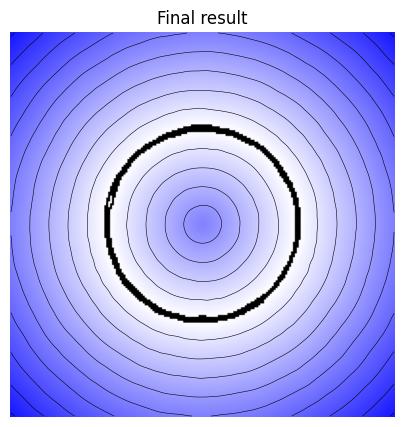

lambda_pc 0.01
starting loss, lambda_pc=0.01, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_emd is null
Optimizing NN took 46.62 s.
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


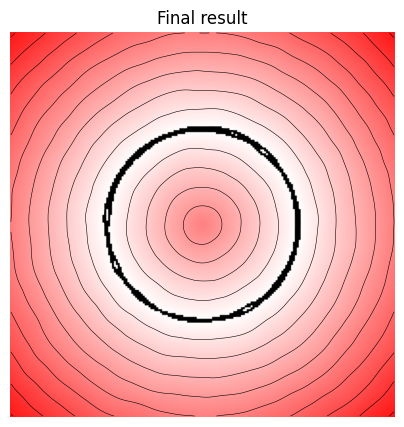

lambda_pc 0.001
starting loss, lambda_pc=0.001, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

lambda_emd is null
Optimizing NN took 46.71 s.
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


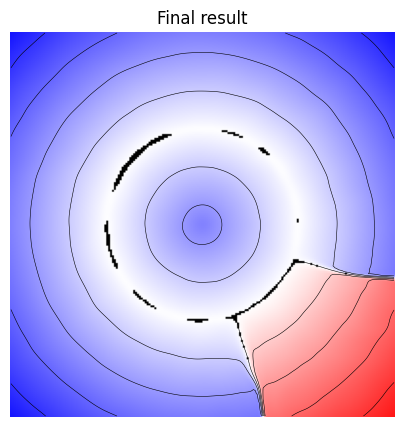

In [ ]:
for lambda_pc in [1000,100,10,1,0.1,0.01,0.001]:
    print("lambda_pc",lambda_pc)
    npl = 128
    depth = 3
    true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
        device
    )
    lpc, leik, lh, llse = [], [], [], []
    lemd=[]
    lgc=[]

    batch_size=2000,
    list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
    pc_t0 = pc0.clone().to(device)
    pts_hintst0 = pts_hints0.clone().to(device)
    # nepochs = 10000
    nepochs=5000
    pc_t0.requires_grad = True
    # nepochs=10
    optimize_nise_vf(
        net=true_net,
        pc0=pc_t0,
        # nc0=nc0,
        hints0=pts_hintst0,
        gtsdf0=gt_sdf_hints0,
        # vf=vf,
        # lpc=lpc,
        # leik=leik,
        # lh=lh,
        # llse=llse,
        # lemd=lemd,
        # lgc=lgc,
        
        lambda_pc=lambda_pc,# 
        lambda_eik=0.001, # eikonal,
        lambda_hint=0, #0.01, # used but need ground truth,
        lambda_lse=0, # not used,
        lambda_gc=0.01, #geometric consistency,
        lambda_emd=0, # lambda EMD,
        batch_size=2000,
        nepochs=nepochs,
        plot_loss=False,
        follow_paper=False,
        list_loss=list_loss,
    )
    # save it 
    torch.save(true_net, "net_vf_128_3.net")
    display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")

0.05 semble le meilleur compromis

starting loss, lambda_pc=0.05, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0
beware HARDCODED version


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

lambda_emd is null
lambda_gc is null
Optimizing NN took 43.79 s.
coords shape before adding t: torch.Size([40000, 2])
sdf shape before reshape: torch.Size([40000, 1])


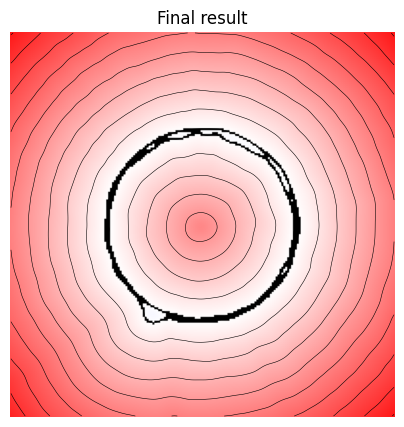

In [ ]:
lambda_pc=0.05
npl = 128
depth = 3
true_net = SirenNet(dim_in=2, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
nepochs = 10000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=lambda_pc,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=0, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=False,
    follow_paper=True,
    list_loss=list_loss,
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")